In [1]:
%tensorflow_version 2.x

In [2]:
# import zipfile
# zfile = zipfile.ZipFile("drive/My Drive/test_dataset/horse.zip")
# zfile.extractall("drive/My Drive/test_dataset/horse/")

In [3]:
# import zipfile
# zfile = zipfile.ZipFile("drive/My Drive/test_dataset/dog.zip")
# zfile.extractall("drive/My Drive/test_dataset/dog/")

In [4]:
import glob
import pandas as pd

catfn = glob.glob("/content/drive/My Drive/test_dataset/horse/horse/*.*")
catans =[0] * len(catfn)
dogfn = glob.glob("/content/drive/My Drive/test_dataset/dog/dog/*.*")
dogans =[1] * len(dogfn)
df = pd.DataFrame({
    "path":catfn + dogfn,
    "target":catans + dogans
})
df

,path,target
0,/content/drive/My Drive/test_dataset/horse/hor...,0
1,/content/drive/My Drive/test_dataset/horse/hor...,0
2,/content/drive/My Drive/test_dataset/horse/hor...,0
3,/content/drive/My Drive/test_dataset/horse/hor...,0
4,/content/drive/My Drive/test_dataset/horse/hor...,0
...,...,...
277,/content/drive/My Drive/test_dataset/dog/dog/9...,1
278,/content/drive/My Drive/test_dataset/dog/dog/9...,1
279,/content/drive/My Drive/test_dataset/dog/dog/9...,1
280,/content/drive/My Drive/test_dataset/dog/dog/9...,1


(950, 425)


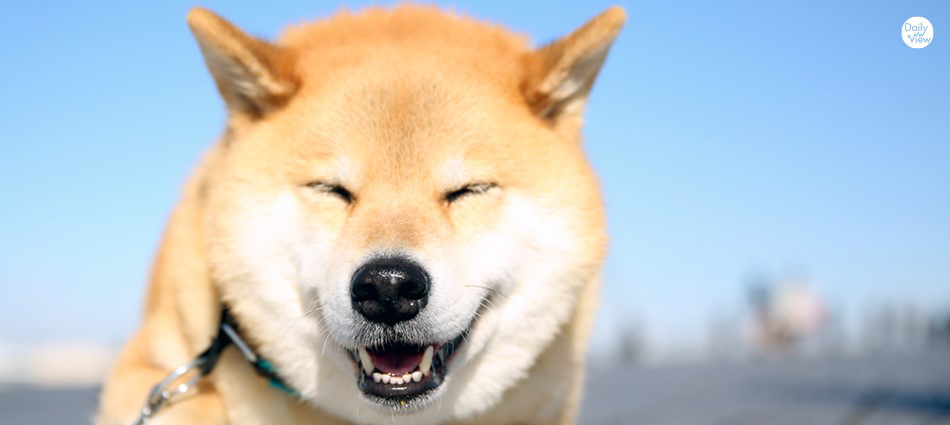

In [5]:
from tensorflow.keras.preprocessing.image import  load_img
p = "/content/drive/My Drive/test_dataset/dog/dog/65.jpg"
img = load_img(p)
print(img.size)
img

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224,224,3))
cnn.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [7]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout
# model = Sequential()
# for l in cnn.layers:
#   #遷移學習 一定要設定 trainable，在compile前必須設定好
#   l.trainable = False
  # model.add(l)
# #遷移學習 資料量較小 不行設定太多層(太多參數)
# model.add(Flatten())
# model.add(Dense(256, activation="relu"))
# model.add(Dropout(0.25))
# model.add(Dense(2, activation="softmax"))

# model.summary()


In [8]:
#用model來取代sequential，但tensor要流動/傳遞
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
for l in cnn.layers:
  #遷移學習 一定要設定 trainable，在compile前必須設定好
  l.trainable = False
x = BatchNormalization()(cnn.output)
#BN 需在 Flatten 之前
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
#test()執行function，再帶入(參數)
#此處test 類似Flatten()()

# def test():
#   return int
# test()(3.14)

In [10]:
#使用Model示範 特定case(有平行的結構，不能用sequential)
# from tensorflow.keras.layers import  Input, Concatenate

# img1 = Input(shape=(224,224,3))
# img1_cnn = cnn(img1)
# img2 = Input(shape=(224,224,3))
# img2_cnn = cnn(img2)
# combine = Concatenate()([img1_cnn,img2_cnn])
# x = Flatten()(combine)
# out = Dense(1, activation="sigmoid")(x)
# Model(inputs=[img1,img2], outputs=out).summary()


In [11]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"]
              )

In [12]:
#好習慣: 全部轉成numpy array ，不要是 series or df，可能有空格
import numpy as np
from sklearn.model_selection import train_test_split
x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [13]:
x_train.shape

(253,)

In [14]:
from tensorflow.keras.applications.vgg16 import preprocess_input
#return value: (原圖，預處理過圖，答案)
def dataflow(x, y , BATCH=10):
  idx = np.random.randint(0, x.shape[0], size=BATCH)
  img_raw, img_process = [],[]
  for p in x[idx]:
    img = load_img(p, target_size=(224,224))
    img_np = np.array(img)
    img_raw.append(img_np)
    img_pre = preprocess_input(img_np)
    img_process.append(img_pre)
  return (np.array(img_raw),
          np.array(img_process), 
          np.array(y[idx]))
data = dataflow(x_train, y_train)
print(data[0].shape, data[1].shape, data[2].shape)

(10, 224, 224, 3) (10, 224, 224, 3) (10,)


In [26]:
for i in range(50):
  print("-"*20 , i ,"-"*20)
  raw, img, ans = dataflow(x_train, y_train)
  train_result = model.train_on_batch(img, ans)
  print("Train:", train_result)
  raw, img, ans = dataflow(x_test, y_test)
  test_result = model.train_on_batch(img, ans)
  print("Validate:", test_result)

-------------------- 0 --------------------
Train: [2.1419757104013115e-05, 1.0]
Validate: [0.0, 1.0]
-------------------- 1 --------------------
Train: [1.6449728718725964e-05, 1.0]
Validate: [1.1920921849650767e-07, 1.0]
-------------------- 2 --------------------
Train: [0.0, 1.0]
Validate: [0.0, 1.0]
-------------------- 3 --------------------
Train: [1.4305105366929638e-07, 1.0]
Validate: [0.0, 1.0]
-------------------- 4 --------------------
Train: [0.0002589075011201203, 1.0]
Validate: [4.768366181906458e-07, 1.0]
-------------------- 5 --------------------
Train: [0.0016942996298894286, 1.0]
Validate: [0.0, 1.0]
-------------------- 6 --------------------
Train: [2.299282823514659e-05, 1.0]
Validate: [2.384185648907078e-08, 1.0]
-------------------- 7 --------------------
Train: [3.346836456330493e-05, 1.0]
Validate: [1.838044772739522e-05, 1.0]
-------------------- 8 --------------------
Train: [0.0, 1.0]
Validate: [0.014639581553637981, 1.0]
-------------------- 9 -----------

In [27]:
# 正常機率: [很小很小, 很大很大]
# 不正常機率: [1, 0]
model.predict(img)

array([[8.8618843e-14, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 7.4652978e-15],
       [1.0000000e+00, 0.0000000e+00],
       [6.5160248e-36, 1.0000000e+00],
       [3.1615856e-22, 1.0000000e+00],
       [1.0000000e+00, 1.6748420e-18],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 2.1722616e-14],
       [1.0000000e+00, 7.4652978e-15]], dtype=float32)

In [28]:
raw, img, ans = dataflow(x_test, y_test, 1000)
model.evaluate(img, ans)

32/32 [==============================] - 2s 63ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [29]:
#Model(非Sequential):沒有predict_classes
#argmax:最大值的索引
pre = model.predict(img).argmax(axis=1)
pre

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
# [:200]: 太多錯, 我只取前兩百個
names = ["Cat", "Dog"]
idx = np.nonzero(pre != ans)[0]
false_pre_img = raw[idx]
false_pre_label = ans[idx]
false_pre_predict = pre[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(14, 20))
for i, img in enumerate(false_pre_img):
    plt.subplot(height, width, i+1)
    t = "[P]:{}\n[O]:{}".format(names[false_pre_predict[i]],
                                names[false_pre_label[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)

<Figure size 1008x1440 with 0 Axes>